In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-10-18 16:00:43--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-10-18 16:00:43 (8.58 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
# data = pd.read_csv('/kaggle/input/heart-disease-risk-prediction-dataset/heart_disease_risk_dataset_earlymed.csv')
words[:8] # pd.head()

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words) # data.isnull().sum() - how many missing values per each column
# pandas - connector between database values and tabular

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers (effectively, tokenizer)
chars = sorted(list(set("".join(words))))
stoi = {'.': 0};          itos = {0: '.'}

for i, s in enumerate(chars):
  stoi[s] = i+1
  itos[i+1] = s

# stoi = {s:i+1 for i,s in enumerate(chars)};   stoi['.'] = 0
# itos = {i:s for s,i in stoi.items()}

list(stoi.items())[:5], list(itos.items())[:5]

([('.', 0), ('a', 1), ('b', 2), ('c', 3), ('d', 4)],
 [(0, '.'), (1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')])

In [ ]:
# build the dataset
""" output: X, y | Tr/Dev/Te. -- 80/10/10; input: words's autoregressive combinations
Block_size to choose | Define edge case of Word-Start & Word-End: it's context of X=000 and prdiction of y=0 ('.')
Words split into Context --> Encode (enumerate as per encoding Dictionary STOI
Convolute Context through Words flow using Context cropping """

block_size = 3          # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
      """
      # assigning intup (x) and output (y: person has Heart Risk or not)
      x = data.drop("Heart_Risk", axis=1)
      y = data["Heart_Risk"]
      """
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  """
  print("x_train:", x_train.shape[0])
  print("x_val:", x_val.shape[0])
  print("x_test:", x_test.shape[0])  """
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
""" # splitting data to train, val and test sets
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.20, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)"""

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n1, (n2-n1), len(words)-n2

(25626, 3203, 3204)

In [ ]:
embed_dim  = 10
vocab_size = 27

g = torch.Generator().manual_seed(21)

C = torch.randn((vocab_size, embed_dim), generator=g)

parameters = [C, W1, b1, W2,  b2]
sum(p.nelement() for p in parameters)

for p in parameters:
  p.requires_grad = True

weight_scale

In [ ]:
# Neural Network setting
embed_dim  = 10      # the dimensionality of the character embedding vectors
hidden_dim = 300     # the number of neurons in the hidden layer of the MLP
vocab_size = 27      # = len(chars)

g  = torch.Generator().manual_seed(2147483647)       # for reproducibility

# model_list = {
#     "Logistic Regression": LogisticRegression(),  # Fill model constructor.
#     "Decision Tree": DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier()
# }

C  = torch.randn((vocab_size, embed_dim),            generator=g)       # Full dictionary, embedded mapping (coordinates of chars)

weight_scale = (2*2/(embed_dim*block_size+hidden_dim))**0.5
W1 = torch.randn((embed_dim*block_size, hidden_dim), generator=g) * weight_scale
b1 = torch.randn(hidden_dim,                         generator=g) * 0.01
# with Tanh    activation
W2 = torch.randn((hidden_dim, vocab_size),           generator=g) * 0.05
b2 = torch.randn(vocab_size,                         generator=g) * 0
# with Softmax activation

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)           # number of parameters in total

for p in parameters:
  p.requires_grad = True

weight_scale

0.11009637651263605

In [ ]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [ ]:
# lri   = []
lossi = []
stepi = []

In [ ]:
batch_size = 164
max_steps  = 30000
lr = 0.15

# model.fit(x_train, y_train)  # Fill training data parameters

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass. FullyConnected class continued
  emb = C[Xb]                                   # embed the characters into vectors | batch x context x in_dim
  embcat  = emb.view(emb.shape[0], -1)          # concatenate the vectors
  hpreact = embcat @ W1 + b1                    # hidden layer PRE-ACTIVATION

  # BatchNorm layer
  # -------------------------------------------------------------

  # -------------------------------------------------------------
  # Non-linearity
  h = F.silu(hpreact)                       # POST-ACTIVATION
  logits = h @ W2 + b2                          # output layer, SCORES
  loss   = F.cross_entropy(logits, Yb[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None       # no grads accumulation, before loss.backward()
  loss.backward()

  # update (Solver fn)
  # lr = lrs[i]
  lr = 0.9*lr if i % 10000 == 0 else lr                    # i < 100000 else 0.03
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])

  stepi.append(i)
  # lossi.append(loss.log10().item())
  lossi.append(loss.item())

  if i % 10000 == 0:
    print(f'{i:7d} / {max_steps: 7d}: {loss.item():.2f}')
    # break
print(len(lossi))

#print(loss.item())

      0 /   30000: 3.33
  10000 /   30000: 2.22
  20000 /   30000: 2.27
30000


In [ ]:
h.shape

torch.Size([164, 300])

In [ ]:
# expected Loss at initialization (Random output)
print(f'{-torch.tensor(1/27).log().item(): .3f}', "- 27 classes benchmark\n")

# Example on 4 classes logits
print(f'{-torch.tensor(1/4).log().item(): .3f}',   "- 4 classes benchmark\n")

logits1 = torch.tensor([0.0, 0.0, 0.0, 0.0]) # y_gt = [2]
probs1  = torch.softmax(logits, dim=0)
loss1   = -probs1[2].log()

# logits2 = torch.tensor([10.0, 6.0, 1.0, 32.0])            # y_gt = [2] ..0
logits2 = torch.randn(27) * 10
probs2  = torch.softmax(logits2, dim=0)
loss2   = -probs2[2].log()

loss1, probs1[0], loss2, probs2[0], logits2

 3.296 - 27 classes benchmark

 1.386 - 4 classes benchmark



(tensor([13.8650,  5.6109,  7.1102,  4.5607,  8.6698,  6.8885,  7.7446,  9.5325,
          4.0412,  7.4804,  6.0623,  4.7065,  6.5147,  5.4583,  9.5239,  6.1274,
          3.8427,  7.5049,  6.1886,  7.8484,  3.8729,  4.3327,  6.3223,  4.1336,
          7.7104,  6.5242,  5.8635], grad_fn=<NegBackward0>),
 tensor([8.6456e-04, 3.6174e-04, 1.9588e-03, 1.4277e-03, 8.8288e-03, 3.9281e-04,
         9.3567e-03, 1.6342e-04, 5.6714e-05, 5.1675e-04, 2.3166e-03, 1.4917e-03,
         8.3583e-03, 1.8964e-03, 1.2206e-05, 3.2475e-04, 3.1504e-03, 6.6813e-03,
         1.8261e-04, 8.4639e-04, 1.3906e-03, 2.4753e-03, 1.1370e-02, 2.2695e-03,
         1.0831e-03, 2.8181e-03, 6.6950e-04], grad_fn=<SelectBackward0>),
 tensor(49.2577),
 tensor(1.8330e-23),
 tensor([ -9.6056,   2.8140,  -6.5098, -18.8769,  -7.3868,   4.1759,   1.7926,
          42.7479,  -1.0222,   4.1992,  24.5317,   5.7170,   3.6263,  15.0091,
          19.9830,   6.2477,  -7.4106,  -8.2491,   5.6199,   2.5558, -15.3414,
          11.6284,  -

In [ ]:
print(loss.item())

2.138993978500366


In [ ]:
"""
plt.hist() on x and y
randn                 - could be zeros or ones. or 1 random number
in - out dims         - parallel with calculaions. answer-first. or the entire flow
wight_scale
2 subplots
track x.std() and x.mean() - графич и аналитич
.view(-1) - аналоги reshape & transpose | equal to Flattening
.tolist()
density=True


"""

tensor(0.0178) tensor(1.0045) 
 tensor(-0.0012) tensor(1.0212)


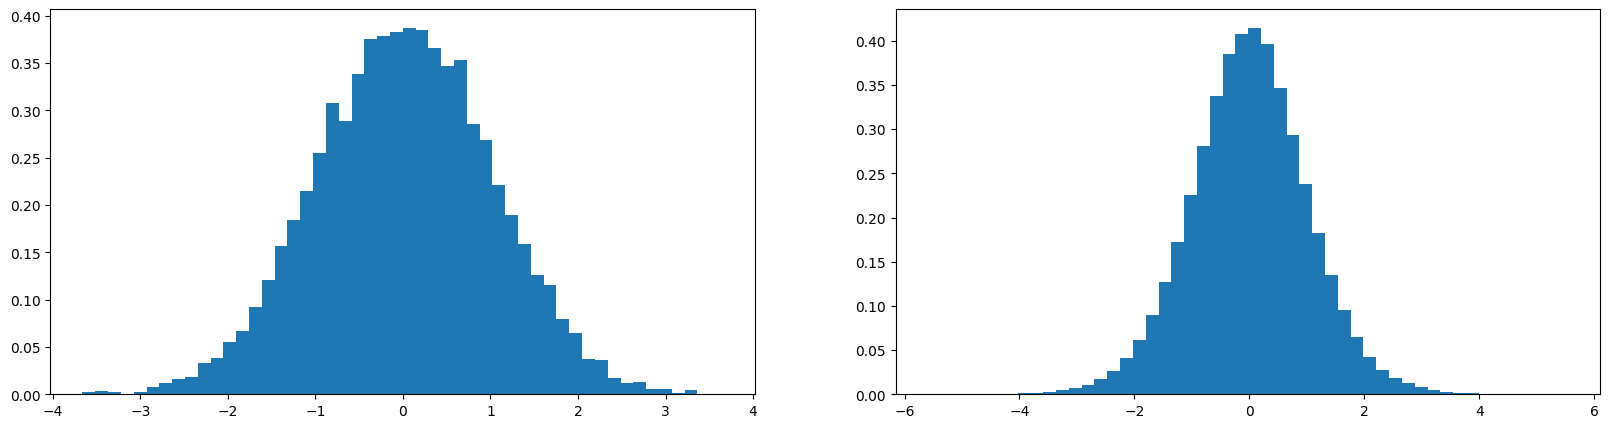

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5

y = x @ w
print(x.mean(), x.std(), "\n", y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

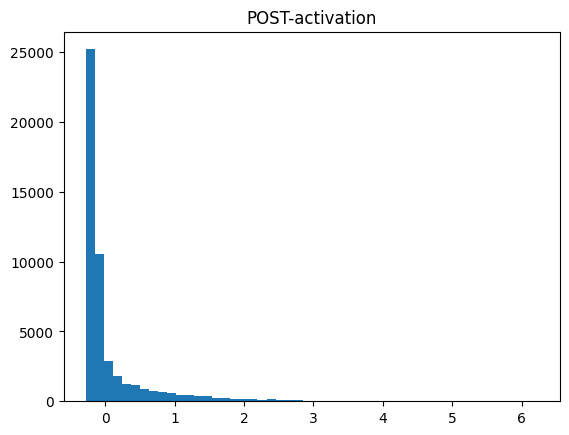

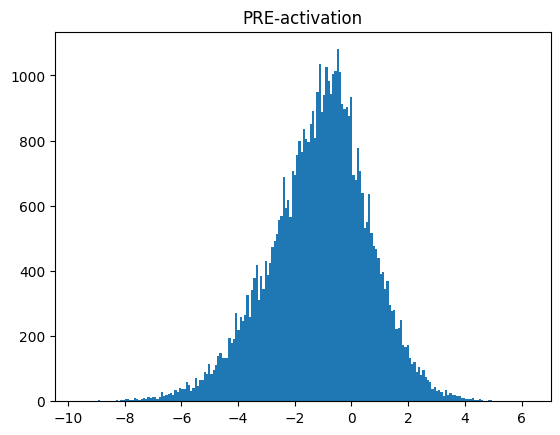

In [ ]:
#1. Vanishing grads - post activation squashed neurons on Tanh
plt.hist(h.view(-1).tolist(),50); plt.title('POST-activation')
plt.show()
plt.hist(hpreact.view(-1).tolist(),200); plt.title('PRE-activation');

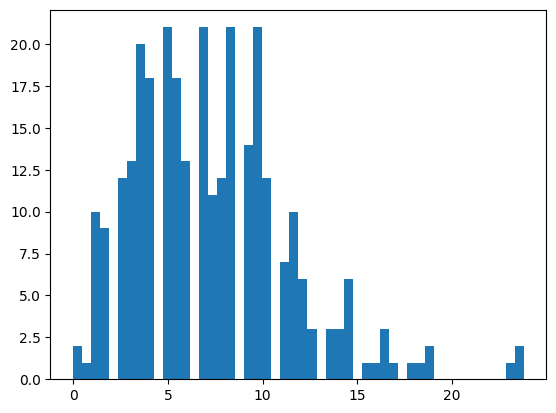

In [ ]:
#2. Vanishing grads - the Map v2
plt.hist(torch.mean((h.abs() > 0.99).float()*100, dim=0).tolist(),50);

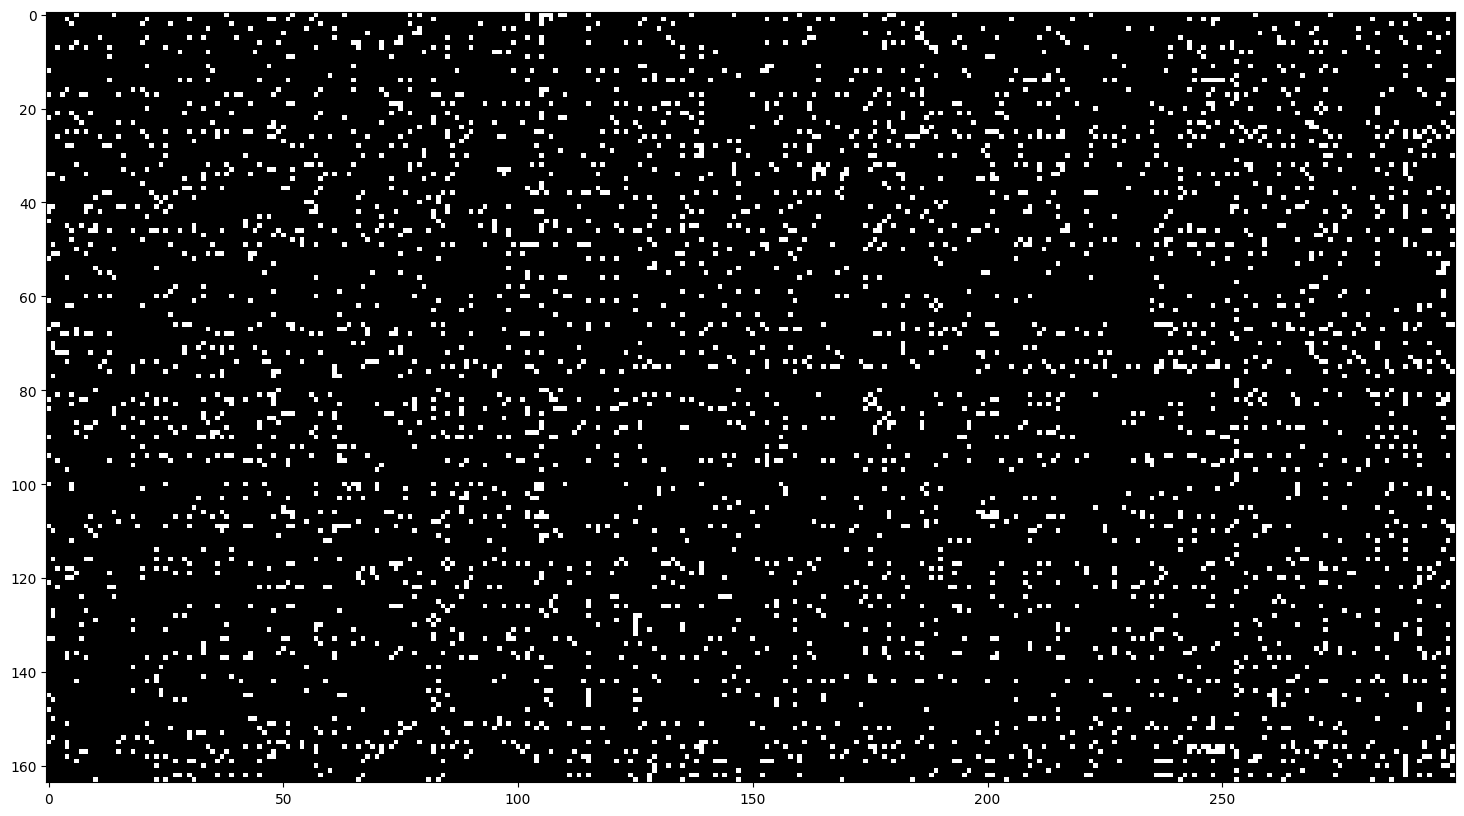

In [ ]:
#2. Vanishing grads - the Map v2
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

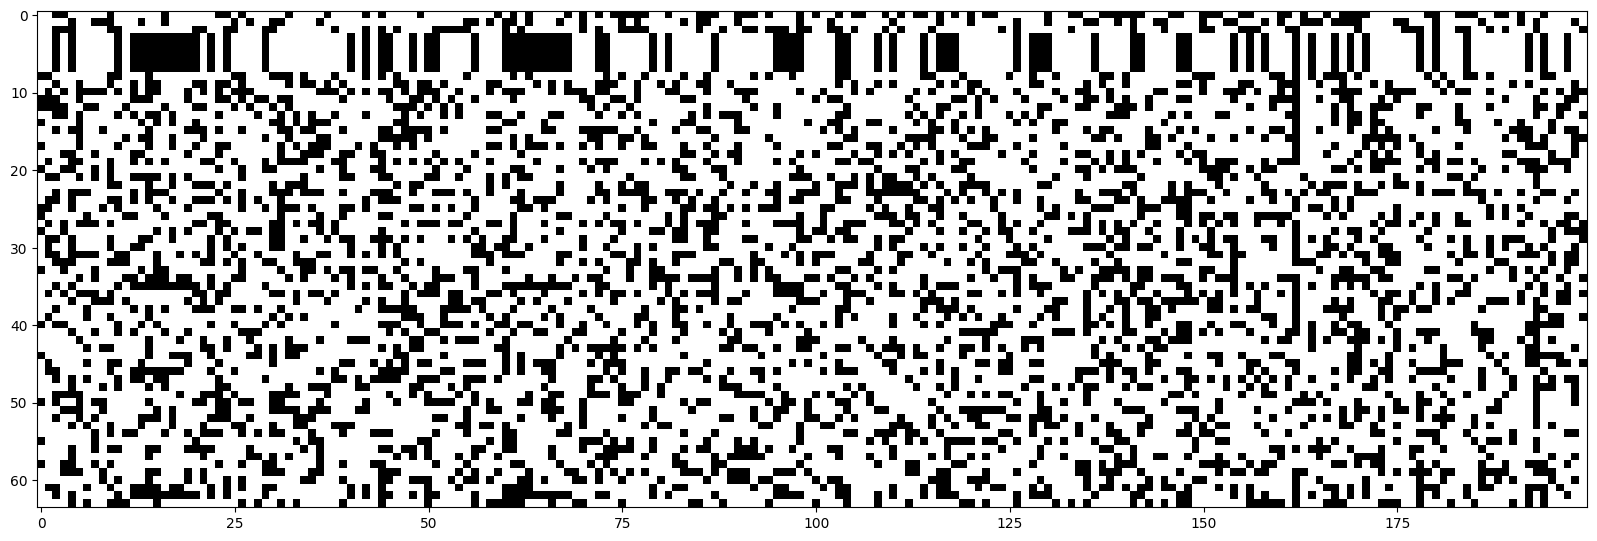

In [ ]:
#2. Vanishing grads - the Map v1 (BEFORE WIGHT_SCALE initializaton)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
stepi, lossi

([0], [3.245666980743408])

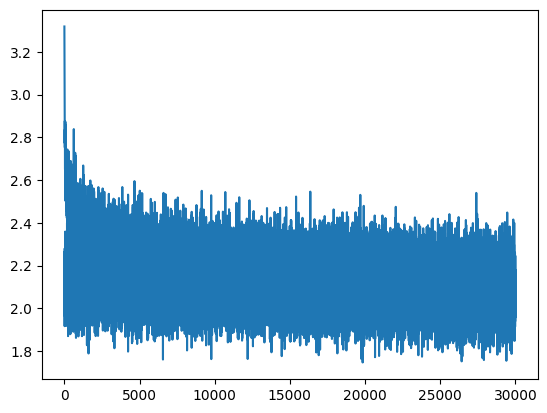

In [ ]:
plt.plot(stepi, lossi);

In [ ]:
emb.shape

torch.Size([64, 3, 10])

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x]                                # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)       # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.relu(hpreact)                   # (N, n_hidden)
  logits = h @ W2 + b2                      # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# accuracy = accuracy_score(y_test, y_hat) # Evaluate accuracy

split_loss('train')
split_loss('val')

train 2.31756854057312
val 2.37544584274292


In [ ]:
# test loss
emb = C[Xte]                                # (N, block_size, n_embd)
embcat = emb.view(emb.shape[0], -1)       # concat into (N, block_size * n_embd)
hpreact = embcat @ W1 + b1
#hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
# hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
h = torch.relu(hpreact)                   # (N, n_hidden)
logits = h @ W2 + b2                      # (N, vocab_size)
loss = F.cross_entropy(logits, Yte)
loss.item()

2.1144163608551025

In [ ]:
plt.figure - figsize=(8,8)
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')


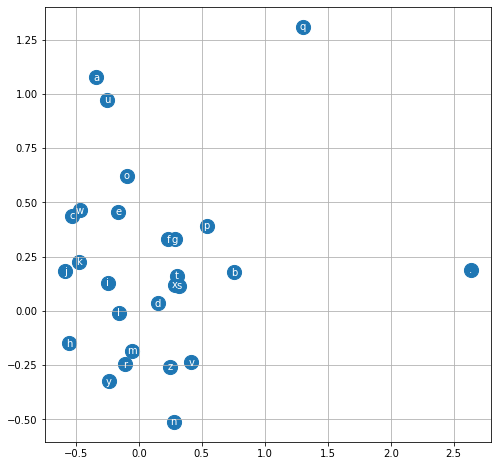

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
print(len(context))

In [ ]:
g = torch.Generator().manual_seed()

for _ in range(20): # ..words
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs  = F.softmax(logits, dim=1)
    ix     = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0: break

  print(''.join(itos[i] for i in out))


In [ ]:
g = torch.Generator().manual_seed()

for _ in range(20): # 20 words to print
  out = []
  context = [0] * block_size # start of word with (...) or zeros while encoded

  while True: # before the break at word end
    emb = C[torch.tenfor([context])]
    h   = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs  = F.softmax(logits, dim=1)
    ix     = torch.multinomial(probs, num_samples=1, generator=g).items()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0: break
  print(''.join(itos[i] for i in out))

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

cbrpzhxqab.
hqvufkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqhiu.
rrmuqptcmziivdyxlhggphhlm.
poin.
qbqjtzsrlivwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoia.
gtlffhysflqohpqgmovdjhksyjrpmqqosozswjcojqmiyojsfrenqkpfsadlnuo.
zoebsrkoiyzhrynhr.
opklhynrxyh.
xqioloqbplbvbbdn.
ipyqmuitjpbvfpzpddgpycsislqwkkmcrnzauqnyjydpk.
kvweskatikzamdtevl.
ky.
qdyltoorowooktbymouokfbfcw.
zolndzcs.
nu.
eoaiunqqerosci.
icfzykbadyieluglconwzyzdjokhnlhjjqsxmuadltjhvtoyaplwuw.
